# Seguimento de junta através de sistema de triangulação a laser

O presente relatório discute os resultados obtidos com um protótipo de sistema de triangulação a laser, capaz de identificar as posições de juntas de topo, de canto e sobre uma linha luminosa projetada, sobre a peça, por um feixe de laser. No primeiro caso, a posição da junta foi estimada a partir da interseção desta com a linha luminosa. Nos dois últimos, isso foi feito através da reconstrução do perfil projetado pelo laser sobre a superfície da peça. As correções na trajetória da tocha de solda foram realizadas através de controle proporcional-integral-derivativo (PID). Para tanto, o controlador lógico-programável (CLP) do manipulador robótico foi integrado a um computador pessoal por meio de protocolo Modbus TCP.

As seções a seguir descrevem de maneira detalhada as etapas envolvidas no seguimento de junta. Futuras menções ao termo **posição** ou **coordenadas** da junta farão referência apenas as coordenadas (em pixels) onde a linha projetada pelo laser cruza a junta.

## O protótipo

Durante etapas anteriores do projeto, descritas nos relatórios 1 a 3, foi observado que o processamento das imagens era bastante prejudicado pela ocorrência de *aliasing* e por reflexos sobre a superfície da peça. Uma vez que o *aliasing* foi observado apenas durante a soldagem, foi tomado por hipótese que esse é causado por componentes de alta frequência na intensidade luminosa do arco voltaico. Assim, o uso de um filtro passa-bandas foi proposto para solucionar o problema. Uma lente polarizadora, para lidar com os reflexos na superfície da peça, também foi proposta.  

O protótipo usado neste trabalho compreende:
* Uma câmera com três canais de cores (RGB), resolução de 640x480 pixels, taxa de amostragem de 30 frames por segundo e resolução de cor de 8 bits.
* Um laser de linha com saída contínua, comprimento de onda de 650 nm e potência de 30 mW.
* Um filtro passa-bandas, com banda de passagem correspondente ao comprimento de onda do laser.
* Uma lente polarizadora de 52 mm de diâmetro.

## O detector de juntas

A classe *joint_tracker* processa as imagens de vídeo a fim de identificar os perfis projetados pelo laser em juntas de canto e sobrepostas e os padrões lineares observados em juntas de topo. A obtenção desses resultados é possível devido ao pré-processamento aplicado as imagens, que inclui filtros gaussianos e filtros de Savitzky-Golay no domínio espacial e de filtros passa-baixas no domínio temporal. As janelas associadas aos dois primeiros e a alocação dos polos dos filtros passa-baixas são passados, como parâmetros, ao construtor da classe *joint_tracker*.

O filtro passa baixas $H_{\alpha}(z)$ com polo em $\alpha$ é denotado por:

$$
H_{\alpha}(z) =  \frac{1 - \alpha}{1 - \alpha z^{-1}}
$$

O mesmo fornece a média móvel exponencialmente ponderada (*EWMA - Exponentialy Weighted Moving Average*) $\bar{x}_t$ da série temporal $x_t$, tal que:

$$
\bar{x}_t = \alpha\bar{x}_{t - 1} + (1 - \alpha)x_t
$$

Neste trabalho, o filtro $H_{\alpha}(z)$ foi aplicado tanto as séries temporais das coordenadas da junta como a reconstrução do perfil luminoso e à própria imagem. No caso do perfil reconstruído, a estatística EWMA foi usada para garantir a evolução contínua do mesmo ao longo dos intervalos de amostragem. Já no caso das imagens de vídeo, a filtragem ocorreu sobre a intensidade de cada pixel (de maneira isolada) com o objetivo de reduzir o impacto dos respingos de solda. A estatística EWMA permite que a imagem pré-processada se torne mais inerte aos respingos, já que ocorrem ao longo de curtos intervalos de tempo.

O pré-processamento também incluiu a seleção de uma região de interesse sobre a imagem, delimitada por um retângulo. Os comandos executados durante a chamada do construtor da classe permitem que o usuário delimite o mesmo. Ambas as etapas de pré-processamento e processamento ocorrem na região de interesse. A conversão das coordenadas da região de interesse em termos das coordenadas da imagem é feita pelo método *joint_tracker.convert_ROI_coordinates*.

In [1]:
import os
import cv2
import numpy as np
import padasip as pa
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pyModbusTCP.client import ModbusClient
from scipy.signal import savgol_filter
from control import TransferFunction
from IPython.utils import io
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams["legend.loc"] = 'best'

class joint_tracker:
    def __init__(self, source,
                 blur_kernel_size_1 = 17, blur_kernel_size_2 = 17,
                 savgol_window_size_1 = 27, savgol_window_size_2 = 27,
                 laser2d = True,
                 alpha_1 = .9, alpha_2 = .9, alpha_3 = .9, alpha_4 = .9,
                 control_params = (.5, .001, .2)):
        
        """
            Parâmetros do seguidor de junta
        """
        
        self.blur_kernel_size_1 = blur_kernel_size_1
        self.blur_kernel_size_2 = blur_kernel_size_2
        self.savgol_window_size_1 = savgol_window_size_1
        self.savgol_window_size_2 = savgol_window_size_2
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.alpha_3 = alpha_3
        self.alpha_4 = alpha_4
        self.laser2d = laser2d
        self.control_params = control_params
        
        """
            Variáveis do seguidor de junta
        """
        
        self.bright_line = np.array([])
        self.bright_line_EWMA = np.array([0])
        self.laser_profile_x = []
        self.laser_profile_y = []
        self.laser_profile_x_EWMA = [np.zeros(300)]
        self.laser_profile_y_EWMA = [np.zeros(300)]
        self.dy = []
        self.laser_profile = None
        
        self.timer = 0
        
        """
            Criação das variáveis de entrada-saída:
             - joint_tracker.img_EWMA: sinal de entrada (média móvel das
               amostras da câmera)
             - joint_tracker.p_EWMA: sinal de saída (média móvel das
               coordenadas da junta)
        """
        
        self.cam = cv2.VideoCapture(source)
        self.set_ROI()
        self.height, self.width = self.dim[1], self.dim[0]
        self.h, self.w = self.height//2, self.width//2
        
        self.img_EWMA = np.zeros((self.height, self.width, 3))
        self.p = np.array([self.w, self.h]).reshape(-1, 1)
        self.p_EWMA = np.array([self.w, self.h]).reshape(-1, 1)
        
    """
        Métodos de manutenção da câmera
    """
        
    def read_frame(self):
        self.current_status, self.current_frame = self.cam.read()
        
        return self.current_frame
    
    def get_status(self):
        return self.current_status

    def get_frame(self):
        return self.current_frame

    def check_camera(self):
        return (cv2.waitKey(1) & 0xFF) != ord('k')

    def release_camera(self):
        self.cam.release()
        cv2.destroyAllWindows()
    
    def get_fps(self):
        timer = cv2.getTickCount() 
        self.fps = cv2.getTickFrequency()/(timer - self.timer)
        self.timer = timer

        return self.fps
    
    """
        Métodos de manutenção da região de interesse
        (ROI - Region Of Interest)
    """
            
    def crop_frame(self):
        self.cropped_frame = self.current_frame[
            self.bbox[1]:(self.bbox[1] + self.bbox[3]),
            self.bbox[0]:(self.bbox[0] + self.bbox[2]), :]
        self.cropped_frame = cv2.resize(self.cropped_frame, 
                                        self.dim, 
                                        interpolation = cv2.INTER_AREA)
        
    def set_ROI(self):
        self.current_status, self.current_frame = self.cam.read()
        self.dim = (self.current_frame.shape[1], self.current_frame.shape[0])
        
        self.bbox = cv2.selectROI(self.current_frame, False)
        
        if((np.array(self.bbox) == 0).all()):
            self.bbox = (0, 0, self.dim[0], self.dim[1])
            
        self.p1 = (int(self.bbox[0]), int(self.bbox[1]))
        self.p2 = (int(self.bbox[0] + self.bbox[2]),
                   int(self.bbox[1] + self.bbox[3]))
        
    def convert_ROI_coordinates(self, p):
        x = (self.bbox[2]/self.width)*np.clip(p[0], 0, self.width) + self.bbox[0] 
        y = (self.bbox[3]/self.height)*np.clip(p[1], 0, self.height) + self.bbox[1]
        
        return x, y
    
    """
        Métodos de monitoramento do seguidor de junta 
    """
    
    def get_pos(self):
        return self.p_EWMA[0, -1] - self.w, self.h - self.p_EWMA[1, -1]

Os métodos a seguir implementam funções auxiliares ao pré-processamento. Tanto a detecção de juntas de topo como a detecção de juntas de canto e sobrepostas empregam estimativas da posição (na imagem) da linha horizontal com maior intensidade luminosa. Considere uma imagem binária onde os pixels não nulos ocorrem majoritariamente sobre o perfil projetado pelo laser. A estimativa da linha com maior intensidade luminosa é feita considerando a linha onde o número de pixels não nulos é máxima.

As etapas envolvidas na obtenção da imagem binária são listadas a seguir:
* Aplicação de filtro gaussiano ao frame mais recente da estatística EWMA das imagens de vídeo;
* Diferenciação da imagem ao longo da direção vertical - i. e., dada a intensidade $I_{i, j}$ no $(i, j)$-ésimo pixel, têm-se $I_{i, j + 1} - I_{i, j}$;
* Transformação logarítmica da imagem - i. e., $\log{\big (}{I_{i, j}}{\big )}$;
* Aplicação de filtro gaussiano a imagem pré-processada;
* Binarização da imagem de acordo com um limiar (um terço da intensidade máxima observada na imagem).

In [2]:
def log_transform(self, img):
    c = 255 / np.log(1 + np.max(img))
    log_img = c*(np.log(img + 1))
    log_img = np.array(log_img, dtype = np.uint8)

    return log_img

def extract_laser_profile(self):
    tmp = cv2.cvtColor(self.img_EWMA, cv2.COLOR_BGR2GRAY)
    # Filtro gaussiano
    tmp = cv2.GaussianBlur(tmp, (self.blur_kernel_size_1,
                                 self.blur_kernel_size_1), 0)
    # Diferenciação na direção vertical
    for i in range(2):
        tmp = tmp[1:-1, :] - tmp[0:-2, :]
    # Transformação logarítmica
    tmp = self.log_transform(tmp)
    # Filtro Gaussiano
    tmp = cv2.GaussianBlur(tmp, (self.blur_kernel_size_2,
                                 self.blur_kernel_size_2), 0)
    # Binarização
    _, tmp = cv2.threshold(tmp, np.max(tmp)//3,
                           np.max(tmp), cv2.THRESH_BINARY)

    self.operated_frame = [tmp]

    return tmp

def brightest_line(self):
    tmp = self.operated_frame[0].copy()
    row_sum = np.sum(tmp, axis = 1)
    # Estimativa da posição da linha com maior
    # intensidade luminosa
    y = np.argmax(row_sum)
    # Filtragem (passa-baixas) da série temporal
    # com o histórico das estimativas
    self.bright_line = np.append(self.bright_line, y)
    self.bright_line_EWMA = np.append(self.bright_line_EWMA,
                                      self.alpha_1*self.bright_line_EWMA[-1] +
                                      (1 - self.alpha_1)*y)

    self.bright_lines = [self.bright_line_EWMA[-1]]

    return self.bright_line[-1], self.bright_line_EWMA[-1]

joint_tracker.log_transform = log_transform
joint_tracker.extract_laser_profile = extract_laser_profile
joint_tracker.brightest_line = brightest_line

Os métodos supracitados são chamados pelo método *joint_tracker.laser_line*, que reconstrói o perfil projetado pelo laser em **juntas de canto e sobrepostas**. Esse realiza uma amostragem  dos pixels não nulos em torno de um intervalo centrado na linha horizontal mais luminosa. A amostragem é aleatória e compreendendo 10% do total de pixels não nulos, a fim de evitar que o perfil reconstruído, por interpolação polinomial local (função *scipy.interpolate.interp1d*), seja distorcido por *aliasing*.

A reconstrução utilizou 300 pontos interpolados de maneira regular ao longo da imagem. Entretanto, dependendo da existência de descontinuidades no perfil original, o perfil reconstruído apresentou padrões periódicos, na forma de dentes de serra. Isto significa que a amostragem foi insuficiente para promover a reconstrução, causando a distorção do perfil reconstruído por *aliasing*. O problema foi solucionado através da amostragem aleatória dos pixels não nulos, que impediu a formação do característico do *aliasing*, sendo esse substituído por perturbações estocásticas. O ruído resultante pode ser removido por filtros de Savitzky-Golay.

O filtro de Savitzky-Golay suaviza o perfil através da interpolação polinomial de amostras vizinhas. A curva resultante apresenta mínimos e máximos, análogos a seções angulosas da superfície da peça. A posição da junta coincide com um destes pontos críticos. Logo, essa ocorre em um dos pontos em que a primeira derivada do perfil reconstruído é nula.

In [3]:
def laser_profile(self):
    _ = self.extract_laser_profile()
    
    # Delimitação do intervalo
    _, b = self.brightest_line()
    self.b_min = int(np.max([b - 200, 0]))
    self.b_max = int(np.min([b + 200, 479]))
    
    # Amostragem aleatória (anti-aliasing)
    y, x = np.nonzero(self.operated_frame[0][self.b_min:self.b_max, :])
    res = list(set(np.random.randint(x.size, size = int(x.size/10))))
    x, y = x[res], y[res]
    
    # Reconstrução do perfil por interpolação polinomial local
    if(x.size > 2):
        f = interp1d(x, y)
        xhat = np.linspace(np.min(x), np.max(x), num = 300)
        yhat = f(xhat)
        yhat = np.nan_to_num(yhat, yhat[1])
        # Filtro de Savitzky-Golay
        yhat = savgol_filter(yhat,
                             window_length = self.savgol_window_size_1,
                             polyorder = 2, deriv = 0) + self.b_min
    else:
        xhat = np.linspace(0, self.width, 300)
        yhat = np.zeros(300)
    
    # Filtragem (passa-baixas) do perfil
    self.laser_profile_x.append(xhat)
    self.laser_profile_y.append(yhat)
    self.laser_profile_x_EWMA.append(self.alpha_2*self.laser_profile_x_EWMA[-1] +
                                     (1 - self.alpha_2)*self.laser_profile_x[-1])
    self.laser_profile_y_EWMA.append(self.alpha_2*self.laser_profile_y_EWMA[-1] +
                                     (1 - self.alpha_2)*self.laser_profile_y[-1])
    
    xhat, yhat = (self.laser_profile_x_EWMA[-1],
                  self.laser_profile_y_EWMA[-1])
    
    # Obtenção da derivada do perfil
    # Filtragem por Savitzky-Golay
    self.dy.append(savgol_filter(yhat,
                                 window_length = self.savgol_window_size_2,
                                 polyorder = 2, deriv = 1))
    
    self.laser_profile = [xhat, yhat, self.dy[-1]]
    # Pontos críticos ao longo do perfil
    res = (np.where(np.diff(np.signbit(self.dy[-1])))[0]).tolist()
    
    x, y = self.p_EWMA[0, -1], self.p_EWMA[1, -1]
    
    # Estimativa da posição da junta
    if(len(res) > 0):
        idx = res[np.argmin(np.abs(xhat[res] - self.w))]
        x, y = self.convert_ROI_coordinates([xhat[idx], yhat[idx]])
        
    return x, y

joint_tracker.laser_profile = laser_profile

O método *joint_tracker.feature_lines* estima a posição da junta em **juntas de topo**. Uma primeira estimativa é obtida considerando a interseção entre:
1. a linha horizontal com maior intensidade luminosidade;
2. e a linha vertical em que a intensidade da diferenciação $I_{i + 1, j} - I_{i, j}$ ($I_{i, j}$ é a intensidade da imagem no pixel com coordenadas $i$ e $j$) é máxima.

Todavia, a reta que incide sobre a junta de topo pode estar inclinada, fazendo com que exista um deslocamento entre a verdadeira interseção e a estimativa anterior. Uma estimativa mais precisa pode ser obtida por meio do método de Hough. Nesta abordagem, a derivada horizontal da imagem foi submetida a transformada de Hough, com limiar igual ao valor máximo obtido no item 2 da abordagem anterior.

Os coeficientes angulares e lineares das retas identificadas foram calculados e as médias $\bar{a}$ e $\bar{b}$ dos mesmos foram assumidas como parâmetros da reta ($y = \bar{a}x + \bar{b}$) que incide sobre a junta de topo. O coeficiente angular da reta que passa sobre a linha luminosa foi desprezado, uma vez que assume valores bastante baixos ($\ll 1$), e essa foi representada apenas por sua coordenada vertical (i. e., $y = \hat{b}$). Desta forma, foi possível obter a coordenada $x$ da posição da junta:

$$
x = \frac{\hat{b} - \bar{b}}{\bar{a}}
$$

Os coeficientes $\bar{a}$ e $\bar{b}$ foram calculados a cada intervalo de amostragem e suas respectivas séries temporais foram submetidas a filtros passa-baixas, para evitar mudanças abruptas nas estimativas das coordenadas da junta. 

In [4]:
def feature_lines(self):
    # Derivada da imagem ao longo da direção horizontal
    gray = cv2.cvtColor(self.img_EWMA, cv2.COLOR_BGR2GRAY)
    tmp = gray[:, 1:-1] - gray[:, 0:-2]
    tmp = cv2.boxFilter(tmp, -1, (13, 13), normalize = True)
    # Binarização da imagem processada
    _, tmp = cv2.threshold(tmp, 2*np.max(tmp)//3, np.max(tmp),
                           cv2.THRESH_BINARY)
    
    # Cálculo da linha vertical encerrando o maior número de
    # pixels não nulos
    col_sum = np.sum(tmp, axis = 0)
    x = np.argmax(col_sum)
    max_col_sum = col_sum[x]//np.max(tmp)
    
    # Transformada de Hough
    lines = cv2.HoughLines(tmp, 1, np.pi/180,
                                max_col_sum, None, 0, 0)
    
    # Estimativa da linha com maior intensidade luminosa
    _ = self.extract_laser_profile()
    _, y = self.brightest_line()
    
    if(lines is not None):
        lines = lines.ravel()
        r, theta = lines[0::2], lines[1::2]
        # Estimativa da reta passando pelo gap
        a = np.mean(-np.cos(theta)/np.sin(theta))
        b = np.mean(r/np.sin(theta))
        # Filtragem dos parâmetros da reta
        self.a = self.alpha_2*self.a + (1 - self.alpha_2)*a
        self.b = self.alpha_2*self.b + (1 - self.alpha_2)*b
        # Estimativa da interseção entre o gap e a linha
        # projetada pelo laser
        x = np.int64((y - self.b)/self.a)
    
    self.operated_frame.append(tmp)
    
    # Transformação de coordenada:
    #    ROI -> Imagem
    x, y = self.convert_ROI_coordinates([x, y])
    
    self.bright_lines = [y, [self.a, self.b]]
    
    return x, y

joint_tracker.a, joint_tracker.b = 1, 0
joint_tracker.feature_lines = feature_lines

O método empregado para estimar as coordenadas da junta pode ser selecionado conforme o parâmetro *joint_tracker.laser2d*. A classe *joint_tracker* mantém as séries temporais das estimativas e a estatística EWMA das mesmas. A diferença entre as séries temporais e as respectivas médias móveis é usada para avaliar a variância da trajetória em janelas de dez intervalos de amostragem.

Quando a variância é maior que um determinado limiar (menor ou igual a 3 na célula de código abaixo), o algoritmo considera que as estimativas são inadequadas, e a variável *joint_tracker.enable_control* é mantida igual a zero. Caso contrário, é mantida igual a um. A mesma foi usada para habilitar ou desabilitar o envio de sinais de controle para o manipulador robótico.

In [5]:
def predict(self):
    self.img_EWMA = np.uint8(self.alpha_4*self.img_EWMA +
                             (1 - self.alpha_4)*self.cropped_frame)
    # Estimativa das coordenadas da junta
    x, y = self.method()
    # Filtragem (passa-baixas) das coordenadas
    p = np.array([x, y]).reshape(-1, 1)
    p_EWMA = self.alpha_3*self.p_EWMA[:, -1] + (1 - self.alpha_3)*p[:, 0]
    self.p = np.concatenate([self.p, p], axis = 1)
    self.p_EWMA = np.concatenate([self.p_EWMA, p_EWMA.reshape(-1, 1)],
                                 axis = 1)
    # Monitoramento da variância da série temporal
    # Mudança do status do controle (habilitado/desabilitado)
    if(self.p_EWMA.shape[1] < 10):
        self.enable_control = np.append(self.enable_control, 0)
    elif(np.var(self.p_EWMA[0, -10:] - self.p[0, -10:]) <= 3):
        self.enable_control = np.append(self.enable_control, 1)
    else:
        self.enable_control = np.append(self.enable_control, 0)
        
    return p_EWMA

joint_tracker.enable_control = np.array([])
joint_tracker.control = np.array([])

joint_tracker.method = joint_tracker.laser_profile
joint_tracker.predict = predict

Os métodos abaixo foram criados para a exibição dos resultados. O método *joint_tracker.imshow* exibe uma imagem de quatro quadrantes, contendo:
* Quadrante superior esquerdo: a imagem de vídeo, com a estimativa da posição da junta indicada por uma bola, que pode ser verde ou vermelha dependendo da variável *joint_tracker.enable_control*;
* Quadrante superior direito: um gráfico com os 100 últimos valores do sinal de controle;
* Quadrante inferior esquerdo: um gráfico com os 100 últimos valores da coordenada $x$;
* Quadrante inferior direito: um gráfico com os 100 últimos valores da coordenada $y$.

O método *joint_tracker.imshow_debug* exibe as etapas intermediárias dos algoritmos utilizados nos métodos *joint_tracker.laser_line* e *joint_tracker.feature_lines*.

In [6]:
def plot_lines(self, signal, text, color, ylim):        
    x = np.linspace(40, self.width - 40, signal.size, dtype = np.int64)
    
    blank_img = 255*np.ones((self.height, self.width, 3), dtype = np.uint8)
    
    draw_points = (np.asarray([x, signal]).T).astype(np.int64)
    x_circle, y_circle = draw_points[-1]
    
    cv2.line(blank_img, (0, self.h), (self.width, self.h), 0, 1)
    cv2.line(blank_img, (100, 0), (100, self.height), 0, 1)
    cv2.polylines(blank_img, [draw_points], False, (255, 0, 0))
    cv2.circle(blank_img, (x_circle, y_circle), 10, color, -1)
    
    pos = 50
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    for t in text:
        cv2.putText(blank_img, t, (10, pos), font, 0.5,
                    (255, 0, 0), 2)
        pos += 20

    cv2.putText(blank_img, str(ylim), (100, 140), font, 0.5, (0, 0, 0), 0)
    cv2.putText(blank_img, str(-ylim), (100, 340), font, 0.5, (0, 0, 0), 0)
    
    return blank_img

def imshow(self):
    img = self.current_frame.copy()
    
    idx = int(self.enable_control[-1])
    color = self.colors[idx]
    state = self.control_state[idx]
    
    x, y = np.round(self.get_pos())
    
    self.plot_control = np.append(self.plot_control, self.control[-1])[1:]
    self.plot_x = np.append(self.plot_x, x)[1:]
    self.plot_y = np.append(self.plot_y, y)[1:]
    
    cv2.rectangle(img, self.p1, self.p2, (255, 255, 0), 2, 1)
    cv2.line(img, (0, self.h), (self.width, self.h), (255, 0, 0), 2)
    cv2.line(img, (self.w, 0), (self.w, self.height), (0, 0, 255), 2)

    cv2.circle(img, (int(self.plot_x[-1] + self.w),
                     int(self.h - self.plot_y[-1])), 10, color, -1)
    cv2.circle(img, (self.w, self.h), 3, [0, 255, 255], -1)
    
    text = [
        "Deslocamento (x, y): {}".format(str(int(self.plot_x[-1])) +
                                         ', '+ str(int(self.plot_y[-1]))),
        "Controle: " + state,
        "FPS: {}".format(str(int(self.fps)))
        ]
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    pos = 50
    
    for t in text:
        cv2.putText(img, t, (10, pos), font, 0.5, color, 2)
        pos += 20

    shift = self.plot_control[-1]
    max_ctrl = np.max(np.abs(self.plot_control))
    control_output = np.int64(-100*self.plot_control/
                              np.max([max_ctrl, 1]) + self.h)
    
    text = ["Sinal de controle (mm): {}".format(shift)]
    
    new_img = self.plot_lines(control_output, text, color, max_ctrl)
    img = np.concatenate((img, new_img), axis = 1)
    
    x_max = np.clip(np.max(np.abs(self.plot_x)), 1, self.width)
    x_output = self.h - (100/x_max)*self.plot_x
    
    text = ['Coordenada x (pixels): {}'.format(round(self.plot_x[-1]))]
    
    new_img = self.plot_lines(x_output, text, color, round(x_max))
    tmp = new_img.copy()
    
    y_max = np.clip(np.max(np.abs(self.plot_y)), 1, self.height)
    y_output = self.h - (100/y_max)*self.plot_y
    
    text = ['Coordenada y (pixels): {}'.format(round(self.plot_y[-1]))]
    
    new_img = self.plot_lines(y_output, text, color, round(y_max))
    
    new_img = np.concatenate((tmp, new_img), axis = 1)
    img = np.concatenate((img, new_img), axis = 0)
    
    height, width = img.shape[0:2]
    dim = (int(.8*width), int(.8*height))
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    
    cv2.imshow('camera - results', img)
    
    return img

def laser_profile_debug(self):
    op_frame = self.operated_frame[0]
    b_line = self.bright_lines[0]
    img = cv2.cvtColor(self.img_EWMA, cv2.COLOR_BGR2GRAY)
    
    tmp = img.copy()
    img = img[:op_frame.shape[0], :]
    img = np.concatenate((img, op_frame), axis = 1)

    cv2.line(tmp, (0, int(b_line)), (self.width, int(b_line)),
             (0, 0, 0), 2)
    draw_points = (
        np.asarray([self.laser_profile[0],
                    self.laser_profile[1]]).T).astype(np.int64)
    cv2.polylines(tmp, [draw_points], False, (0, 0, 0))

    blank_img = 255*np.ones((self.height, self.width), dtype = np.uint8)
    
    if(len(self.laser_profile[2]) > 0):
        draw_points = (
            np.asarray([self.laser_profile[0],
                        self.h + 40*self.laser_profile[2]]).T).astype(
                            np.int64)
        cv2.polylines(blank_img, [draw_points], False, 0)
        cv2.line(blank_img, (0, self.h), (self.width, self.h), 0, 1)

    tmp = np.concatenate((tmp, blank_img), axis = 1)
    img = np.concatenate((img, tmp[:img.shape[0], :]), axis = 0)

    h, w = img.shape[0:2]
    dim = (int(.8*w), int(.8*h))
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    
    cv2.imshow('camera - debug', img)
    
    return img

def feature_lines_debug(self):
    img = cv2.cvtColor(self.img_EWMA, cv2.COLOR_BGR2GRAY)
    
    tmp = img.copy()
    img = np.concatenate((img, self.operated_frame[1]), axis = 1)
    
    y, coef = self.bright_lines
    
    pt1 = (int((-1000 - coef[1])/coef[0]), -1000)
    pt2 = (int((1000 - coef[1])/coef[0]), 1000)
    
    cv2.line(tmp, pt1, pt2, (0, 0, 0), 2)
    cv2.line(tmp, (0, int(y)), (self.width, int(y)), (0, 0, 0), 2)
    
    tmp = np.concatenate((self.operated_frame[0],
                          tmp[:self.operated_frame[0].shape[0], :]),
                         axis = 1)
    img = np.concatenate((img, tmp[:, :img.shape[1]]), axis = 0)

    h, w = img.shape[0:2]
    dim = (int(.8*w), int(.8*h))
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    
    cv2.imshow('camera - debug', img)
    
    return img

def imshow_debug(self):
    img = self.debug()
    img = cv2.resize(np.uint8(img), (640, 480),
                     interpolation = cv2.INTER_CUBIC)
    img = np.stack((img,)*3, axis = -1)
    
    return img

"""
    Variáveis da exibição dos resultados
"""
joint_tracker.plot_x = np.zeros(100)
joint_tracker.plot_y = np.zeros(100)
joint_tracker.plot_control = np.zeros(100)
joint_tracker.control_state = ['Desabilitado', 'Habilitado']
joint_tracker.colors = [(0, 0, 255), (0, 255, 0)]

"""
    Métodos da exibição dos resultados
"""
joint_tracker.plot_lines = plot_lines
joint_tracker.imshow = imshow
joint_tracker.laser_profile_debug = laser_profile_debug
joint_tracker.feature_lines_debug = feature_lines_debug
joint_tracker.imshow_debug = imshow_debug

joint_tracker.debug = joint_tracker.laser_profile_debug

## Controle retroativo

O controle retroativo do deslocamento da junta em relação ao centro da imagem foi usado para manter o seguimento da mesma. Apenas a posição horizontal foi considerada, sendo a tocha de solda alinhada com a câmera, de modo que o deslocamento (em pixels) da junta é proporcional ao deslocamento (em milímetros) da junta em relação à tocha de solda. Menções futuras do termo **deslocamento** farão referência apenas ao deslocamento horizontal (em pixels) da posição estimada em relação ao centro da imagem.

Durante o controle retroativo, um sinal de controle $u(t)$ é calculado de modo a minimizar um sinal de erro $e(t)$, dado em termos da diferença entre um sinal de referência $r(t)$ e as observações da variável controlada $x(t)$ - i. e., $e(t) = r(t) - x(t)$. Neste trabalho, a variável controlada foi a série temporal EWMA do deslocamento da junta, enquanto o sinal de referência foi nulo (já que o deslocamento deve ser minimizado). Logo, tem-se $e(t) = -x(t)$. 

Um controlador PID foi adotado para implementar o controle retroativo. Dentre as razões que justificam a escolha, é possível citar: a obtenção de erro nulo em estado estacionário, a estabilização do sistema, a redução de constantes de tempo associadas à variável controlada e a facilidade de implementação. O controle PID:

$$
u(t) = K_pe(t) + K_i\int_0^te(\tau)d\tau + K_d\frac{de}{dt}
$$

inclui três ações de controle, a citar:
* A ação proporcional (P) ao sinal de erro, conforme uma constante $K_p$ (ganho proporcional), sendo responsável pela minimização do erro. Todavia, quando $e(t) = 0$, a ação proporcional também é nula e o estado do sistema pode ser facilmente perturbado. Devido a isso, o controle proporcional não é capaz de garantir erro nulo em estado estacionário. O erro em estado estacionário é inversamente proporcional ao ganho $K_p$.
* A ação integral (I), proporcional à integral do sinal de erro. Esta ação é capaz de fornecer erro nulo em estado estacionário, já que retroage sobre o histórico do sinal $e(t)$. A velocidade com que a variável controlada converge para o sinal de referência depende da magnitude do ganho integral $K_i$. Se esse é muito baixo, o sistema se torna mais lento. Por outro lado, valores mais altos tornam a variável controlada bastante oscilatória e o sistema pode se tornar instável.
* A ação derivativa (D), proporcional à derivada do sinal de erro, conforme o ganho derivativo $K_d$. Esta ação de controle antecipa a tendência do erro, melhorando a estabilidade do sistema. A ação derivativa previne a ocorrência de percentuais de sobressinal elevados, que podem ocorrem durante o controle PI.

Como as imagens são amostradas pela câmera, com período de amostragem $T_s$ variando entre 0,03 e 0,05 segundos, têm-se um sistema de tempo discreto. Logo, é necessário considerar aproximações discretas do controle PID. A equação abaixo apresenta a transformada $\mathcal{Z}$ de um controlador discreto análogo ao controlador PID.

$$
C(z) = K_p + K_iT_s\frac{z}{z - 1} + \frac{K_d}{T_s}\frac{z - 1}{z}
$$

A integral e a derivada foram substituídas pela acumulação

$$
\frac{z}{z - 1}E(z) = \frac{1}{1 - z^{-1}} = \sum_{k = 0}^{\infty}z^{-k}E(z) \Rightarrow \mathcal{Z}^{-1}{\Big \{}\frac{z}{z - 1}E(z){\Big \}} = \sum_{k = 0}^{\infty}e_{t - k}
$$

e pela diferenciação

$$
\frac{z - 1}{z}E(z) = (1 - z^{-1})E(z) \Rightarrow \mathcal{Z}^{-1}{\Big \{}\frac{z - 1}{z}E(z){\Big \}} = e_t - e_{t - 1}
$$

Geralmente, a ação de controle derivativa é modificada pela inclusão de um filtro passa-baixas. Isso ocorre, porque as observações da variável controlável podem estar comprometidas por ruído, fazendo com que as diferenciações do sinal de erro apresentem valores excessivos. Tal precaução foi adotada neste trabalho, resultando no controlador:

$$
C(z) = K_p + K_iT_s\frac{z}{z - 1} + \frac{K_dN(z - 1)}{(1 + NT_s)z - 1}
$$

É possível observar que quando $N \rightarrow \infty$, a forma anterior da ação derivativa é restaurada. Quando $N$ assume valores finitos, uma frequência de corte, associada ao pólo $z = 1/(1 + NT_s)$, é imposta à ação derivadiva. A banda de passagem da ação derivativa é menor conforme $N$ se aproxima de zero.

A classe declarada a seguir implementa o controlador $C(z)$. Além de calcular as ações de controle supracitadas, a classe *PID_control* também realiza a saturação e a anulação do sinal de controle e a integração condicional do sinal de erro. Essas operações são realizadas nas seguintes condições:
* Saturação: é aplicada quando o valor absoluto da soma das ações de controle excede um limiar especificado pelo usuário.
* Anulação: ocorre quando as estimativas das coordenadas da junta são pouco precisas - i. e., a variância das estimativas, em torno da respectiva série temporal EWMA, está acima de um dado limiar. Nestas condições, as três ações de controle são anuladas.
* Integração condicional: para evitar que a ação integral acabe saturando o sinal de controle, a mesma é ativada apenas quando o valor absoluto do erro está abaixo de um determinado limiar.

In [7]:
class PID_control:
    def __init__(self, kp, ki, kd, sat):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.sat = sat
        
        self.Ts = 1/30
        self.N = 10
        
        self.control = np.array([])
        
        self.x = np.array([0])
        self.e = np.array([0]) 
        self.E = np.array([0]) 
        self.de = np.array([0]) 
        self.dehat = np.array([0]) 
        
    def update_control(self, x, Ts, enable):
        self.Ts = Ts
        
        self.x = np.append(self.x, x)
        self.e = np.append(self.e, -x*enable)
        self.de = np.append(self.de, -(self.x[-1] - self.x[-2])*enable)
        
        dehat = enable*(self.dehat[-1] + self.N*self.de[-1])/(1 + self.N*Ts)
        self.dehat = np.append(self.dehat, dehat)
        
        if(np.abs(self.e[-1]) <= 10):
            self.E = np.append(self.E, enable*(self.E[-1] + self.Ts*self.e[-1]))
        else:
            self.X = np.append(self.E, 0)
        
        shift = self.kp*self.e[-1] + self.ki*self.E[-1] + self.kd*self.dehat[-1]
        shift = np.clip(shift, -self.sat, self.sat)
        self.control = np.append(self.control, shift)
        
        return shift
    
    def log(self):
        print('\nCONTROLE PID')
        print('Frame: {}'.format(self.control.size))
        print('Período de amostragem: {}'.format(self.Ts))
        
        control_law = 'Controlador: C(z) = {} {} {} {}Tz/(z - 1) {} {}H(z)(z - 1)/z'.format(
            '+' if(self.kp >= 0) else '-', np.abs(self.kp),
            '+' if(self.ki >= 0) else '-', np.abs(self.ki),
            '+' if(self.kd >= 0) else '-', np.abs(self.kd))
        
        print(control_law)
        
        print('Erro: {}'.format(self.x[-1]))
        print('Ação proporcional: {}'.format(self.kp*self.e[-1]))
        print('Ação derivativa: {}'.format(self.kd*self.dehat[-1]))
        print('Ação integral: {}'.format(self.ki*self.E[-1]))
        print('Controle: u(t) = {}'.format(round(self.control[-1])))
        
    def plot_debug(self):
        _ = plt.figure()
        plt.plot(self.control, label = 'Sinal de controle')
        plt.plot(self.kp*self.e, '--', label = 'Ação proporcional')
        plt.plot(self.ki*self.E, '--', label = 'Ação integral')
        plt.plot(self.kd*self.dehat, '--', label = 'Ação derivativa')
        plt.legend()
        plt.xlabel('Frame')
        plt.ylabel('Deslocamento (mm)')
        plt.title('Controle PID')
        plt.show()

Um objeto instanciado da classe *PID_control* foi passado como parâmetro do objeto *jt*, da classe *joint_tracker*. Nesta última, o método *joint_tracker.update_control* foi definido para atualizar o estado do controlador e retornar um sinal de saída. O método *joint_tracker.plot_debug* faz a chamada do método *PID_control.plot_debug* (que exige graficamente as ações que compõem o controle PID) e também exibe: as estimativas das coordenadas (junto as respectivas séries temporais EWMA) e o sinal de controle enviado ao manipulador robótico.

O sinal enviado ao robô difere do sinal calculado pela classe *PID_control*, já que a comunicação com o robô só permite o envio de múltiplos inteiros de milímetros. Dada essa limitação de resolução, o sinal de controle foi arredondado.

In [8]:
def update_control(self):
        x, _ = self.get_pos()
        Ts = 1/self.get_fps()
        enable = self.enable_control[-1]
        
        shift = np.round(self.controller.update_control(x, Ts, enable))
        self.controller.log()
        self.control = np.append(self.control, shift)
        
        return shift

def plot_debug(self, control = None):
    self.controller.plot_debug()
    
    _, ax = plt.subplots(1, 2)
    ax[0].plot(self.p[0, :] - self.w, label = 'Coordenada x',
               color = 'orange')
    ax[0].plot(self.p_EWMA[0, :] - self.w, linestyle = (0, (5, 5)),
               color = 'b', label = 'Coordenada x (EWMA - ' +
               str(self.alpha_3) + ')')
    ax[0].plot(self.h - self.p[1, :], label = 'Coordenada y', color = 'r')
    ax[0].plot(self.h - self.p_EWMA[1, :], linestyle = (0, (5, 5)),
               color = 'g', label = 'Coordenada y (EWMA - ' +
               str(self.alpha_3) + ')')
    ax[0].legend()
    ax[0].set_title('Coordenadas da junta')
    ax[0].set(xlabel = 'Frame', ylabel = 'Deslocamento (pixels)')
    ax[1].plot(self.control, label = 'Controle')
    ax[1].set_title('Sinal enviado ao manipulador robótico')
    ax[1].set(xlabel = 'Frame',
              ylabel = 'Deslocamento (mm)')
    ax[1].legend()
    plt.show()

joint_tracker.update_control = update_control
joint_tracker.plot_debug = plot_debug

## Comunicação com o manipulador robótico

Os CLPs de robôs de solda da Panasonic apresentam uma função de acesso aos dados do robô (*RDA - Robot Data Access*), que permite a comunicação com dispositivos externos. Esta comunicação é feita através de protocolo Modbus TCP em meio físico Ethernet. Neste trabalho, a função RDA foi usada para estabelecer a comunicação entre o CLP do robô (**servidor**) e um computador pessoal (**cliente**).

A classe *cliente_modbusTCP* implementa os comandos necessários para enviar os sinais de controle para o CLP. O método *client_modbusTCP.write_control_signal* foi definido para operar através de comandos *RDA shift*, onde o CLP mantém a soma dos valores enviados como sinal de referência para o robô. Isto equivale a presença de um acumulador $z/(z - 1)$ no sistema.

In [9]:
class client_modbusTCP:
    def __init__(self, ip_address, port):
        self.ip_address = ip_address
        self.port = port
        
        self.client = ModbusClient(host = self.ip_address, port = self.port)
        self.client.open()
        
        res = 0
        
        while(res != 1):
            tmp = self.client.read_holding_registers(9105, 1)
            if(tmp is not None):
                res = tmp[0]
            print("Verificando registradores... {} {}".format(tmp, res))
        
        print("Comunicação iniciada...\n")
    
    def write_control_signal(self, shift):
        if(shift < 0):
            shift = 65535 - np.abs(shift)
        
        res = [self.client.read_holding_registers(9105, 1),
               self.client.write_multiple_registers(
                   9120, [int(shift), 0, 0, 0, 0])]
        
        print('Escrita: {} - {} - {}'.format(int(shift), res[0], res[1]))
        
        return res
    
    def close(self):
        self.client.close()

## Resultados

Como o sistema já possui um polo unitário, devido ao modo de operação *RDA shift*, a ação integral do controle PID foi desconsiderada e apenas o controle PD foi submetido a validação. A fim de exemplificar o funcionamento do sistema de visão computacional, as células de código a seguir apresentam os sinais de controle gerados por um controlador com $K_p = 0,5$, $K_d = 0.2$ e $N = 10$. O sinal de controle, que serve como sinal de referência ao manipulador robótico, foi saturado entre -20 e 20 mm. Os exemplos foram baseados nos arquivos de vídeo *video_01.avi*, *video_02.avi*, *video_03.avi* e *video_04.avi*, anexados na mesma pasta que o presente relatório.

Os arquivos *result_01.avi*, *result_02.avi* e *result_03.avi*, também anexados nesta pasta, apresentam os resultados de experimentos, realizados na célula de soldagem híbrida, onde a correção da trajetória pode ser visualizada. No vídeo *result_03.avi*, sobretudo, é possível observar os gráficos da série temporal EWMA do deslocamento da junta (quadrante inferior esquerdo) e do sinal de controle (quadrante superior direito). O seguimento de junta foi bem-sucedido, mantendo erros da ordem de poucos pixels em estado estacionário.

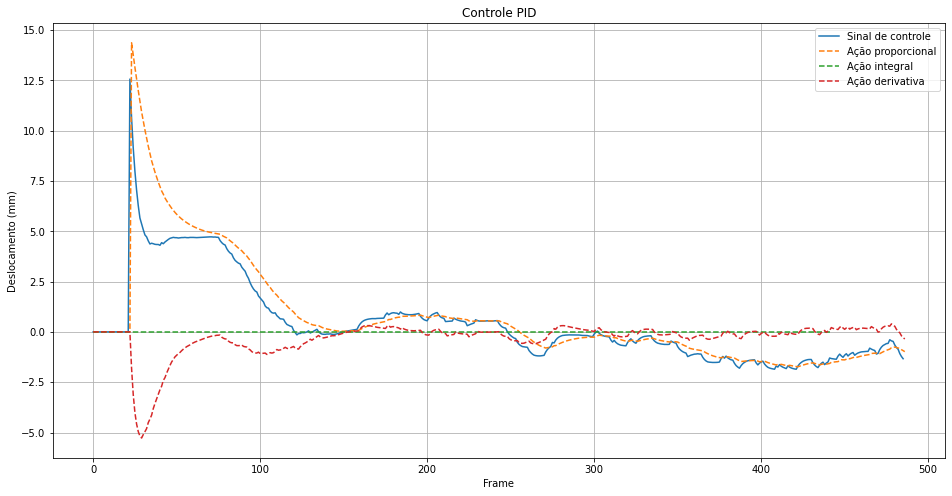

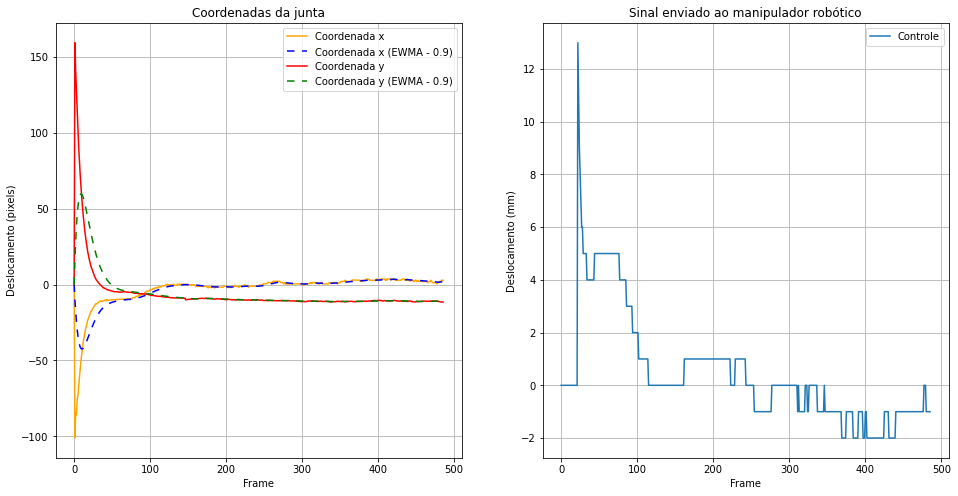

In [10]:
jt = joint_tracker('video_01.avi')
jt.controller = PID_control(.5, 0, .2, 20)

with io.capture_output() as captured:
    while(jt.check_camera()):
        img = jt.read_frame()

        if(jt.get_status()):
            jt.crop_frame()
            _, _ = jt.predict()
            _ = jt.update_control()
            _ = jt.imshow()
            _ = jt.imshow_debug()
        else:
            break
        
jt.plot_debug()
jt.release_camera()

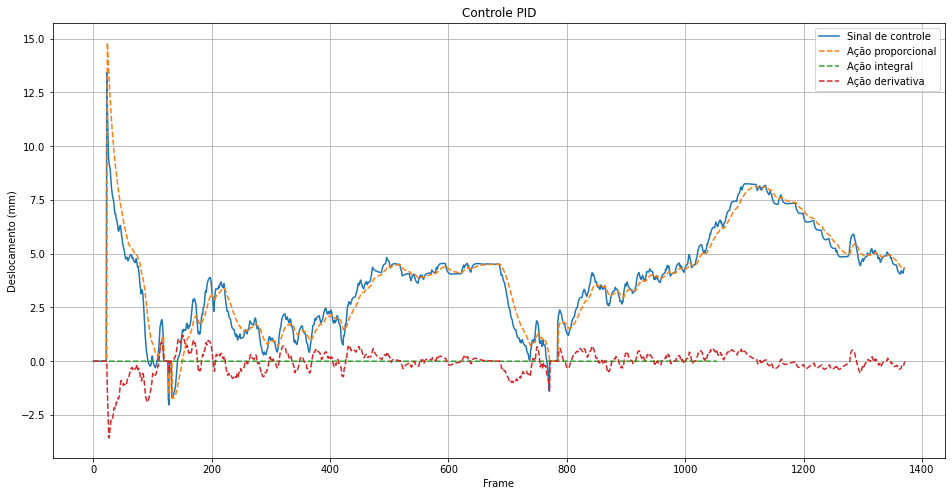

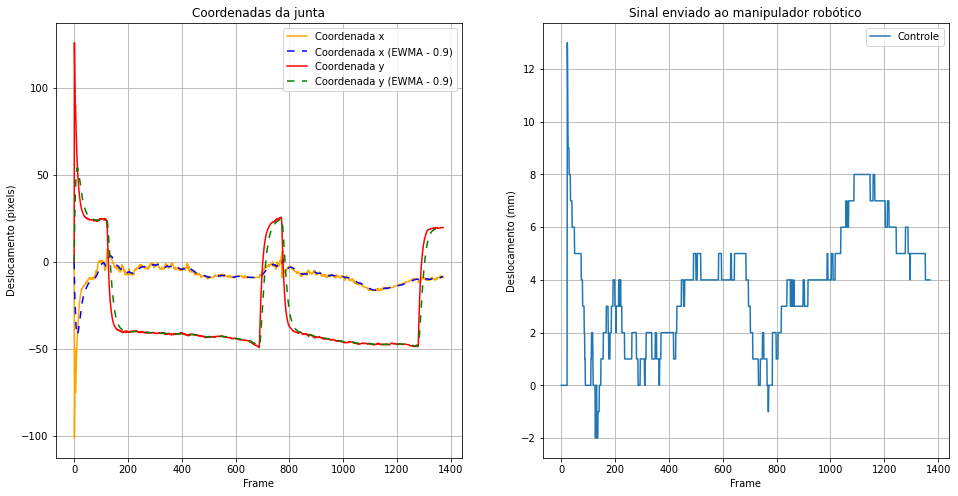

In [11]:
jt = joint_tracker('video_02.avi')
jt.controller = PID_control(.5, 0, .2, 20)

with io.capture_output() as captured:
    while(jt.check_camera()):
        img = jt.read_frame()

        if(jt.get_status()):
            jt.crop_frame()
            _, _ = jt.predict()
            _ = jt.update_control()
            _ = jt.imshow()
            _ = jt.imshow_debug()
        else:
            break
        
jt.plot_debug()
jt.release_camera()

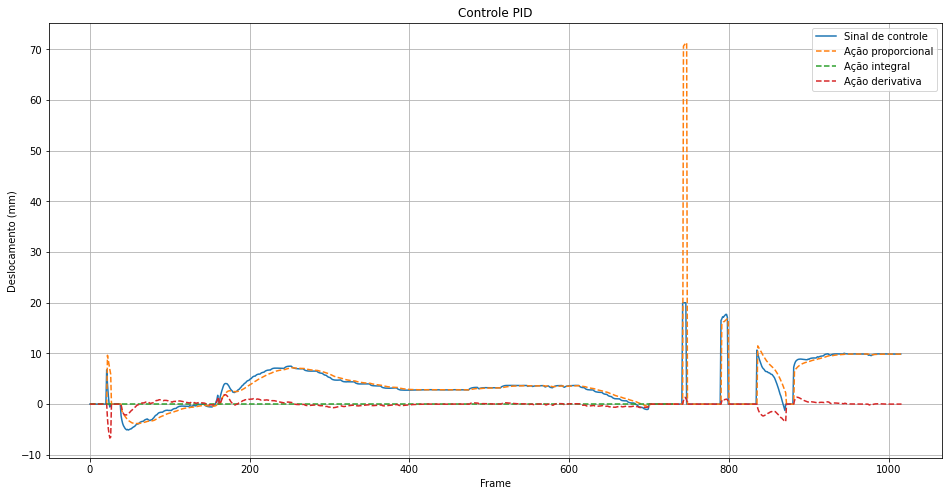

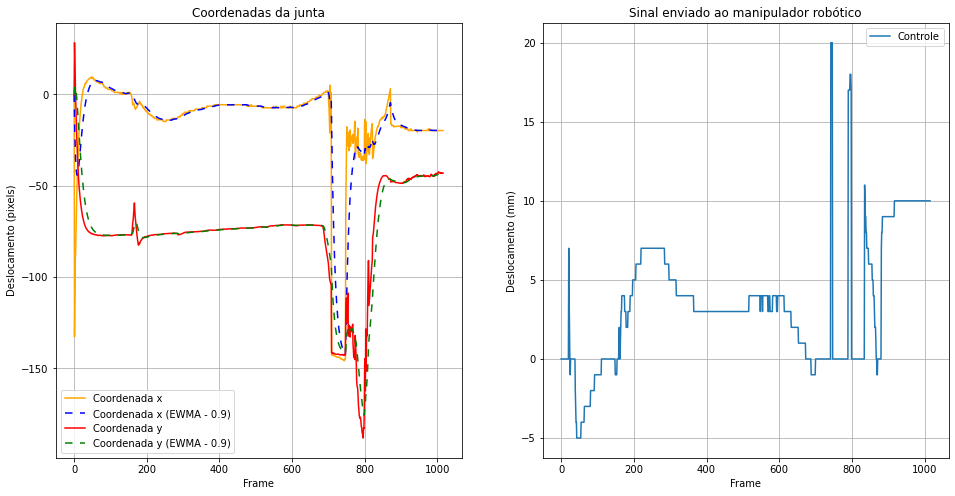

In [12]:
jt = joint_tracker('video_03.avi')
jt.controller = PID_control(.5, 0, .2, 20)

with io.capture_output() as captured:
    while(jt.check_camera()):
        img = jt.read_frame()

        if(jt.get_status()):
            jt.crop_frame()
            _, _ = jt.predict()
            _ = jt.update_control()
            _ = jt.imshow()
            _ = jt.imshow_debug()
        else:
            break
        
jt.plot_debug()
jt.release_camera()

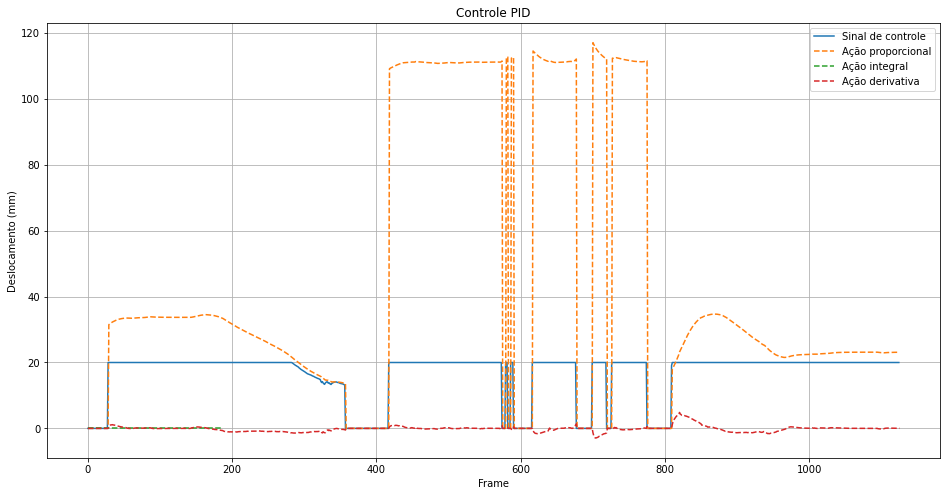

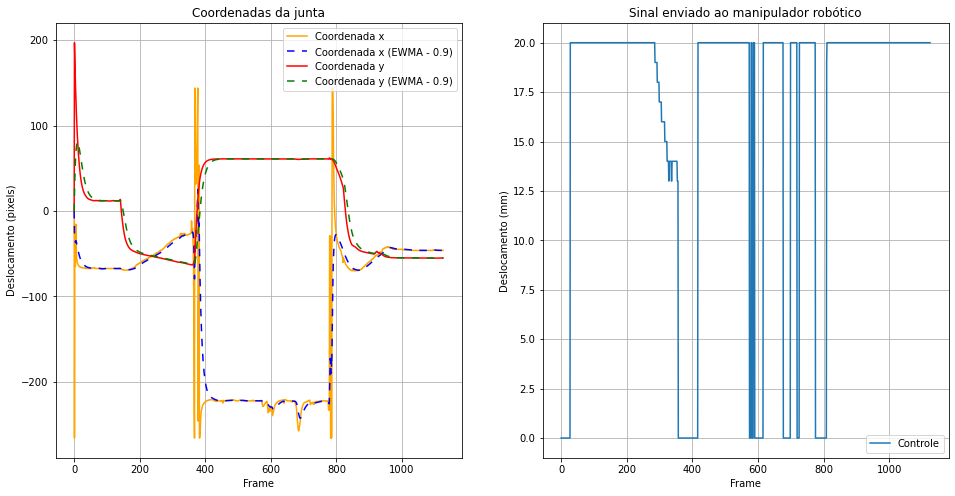

In [13]:
joint_tracker.method = feature_lines
joint_tracker.debug = feature_lines_debug

jt = joint_tracker('video_04.avi')
jt.controller = PID_control(.5, 0, .2, 20)

with io.capture_output() as captured:
    while(jt.check_camera()):
        img = jt.read_frame()

        if(jt.get_status()):
            jt.crop_frame()
            _, _ = jt.predict()
            _ = jt.update_control()
            _ = jt.imshow()
            _ = jt.imshow_debug()
        else:
            break
        
jt.plot_debug()
jt.release_camera()

## Conclusões

Com base nos resultados obtidos neste trabalho e em trabalhos anteriores, é possível enunciar os seguintes avanços:
* A hipótese associando o *aliasing* na amostragem do vídeo a componentes de alta frequência na intensidade luminosa do arco voltaico foi confirmada através da experimentação após a limitação do espectro amostrado por um filtro passa-bandas.
* A reconstrução do perfil projetado pelo laser também foi prejudicada por *aliasing*. Entretanto, o problema pode ser resolvido através da amostragem aleatória de pixels sobre o perfil luminoso.
* A reta que incide sobre a junta de topo é mais facilmente identificável através da derivada horizontal da imagem.
* O modo de operação *RDA shift* induz um polo unitário no sistema, resultando em erro aproximadamente nulo em estado estacionário.
* O controle PD se mostrou capaz de promover a minimização do deslocamento da junta.
* A ferramentas de monitoramento desenvolvidas facilitaram a compreensão do desempenho do seguimento de juntas.